# ♻️Lore Reino de ∑L²:

∑L² significa Eco(logical) Learning, que deriva também dos três governadores da cidade Eloisa, Lorena e Lucas. No Reino de ∑L² a Lógica é preservar de modo a treinar, ensinar e aplicar métodos para que todo o seu povo saiba como ser mais eco(lógico), preservando o reino em que habitam para então poderem viajar para outros reinos e disseminarem a palavra da lógica ecológica, ou seja, do uso consciente dos recursos, da preservação dos reinos, da convivência harmonioza com a natureza. Além disso, com os conhecimentos e treinamentos passados aos habitantes de ∑L² eles adquirem a habilidade de predizerem alguns eventos ambientais a partir de alguns dados que coletam em certo tempo, de modo a poderem a ajudar o seu próprio reino e outros a previnirem catástrofes, saberem como remediá-las ou evitarem o aumento de eventos negativos aos ecossistemas. Para tornarem as suas predições ainda mais confiáveis e precisas os habitantes podem aprender a partir de diferentes metodologias, podendo ser supervisionados ou não, mas para as etapas inciais os governadores preferem o método supervisionado utilizando da Regressão do ambiente.

# ❓Hipótese

Seria possivel treinar um bom modelo de Aprendizagem de Máquina que a partir de dados usualmente coletados para calcular a pegada de carbono(área agrícola, área de pastagem, área florestal, área de pesca e áreas construídas) preveja o valor da pega ecológica total de um local. Além de demonstrar quais atributos tem maior importância para essa predição.

# 📝Introdução

Após algumas análises, decidiu-se utilizar o modelo de Floresta Aleatória para buscar responder a hipótese de que seria possível criar um bom modelo de aprendizagem de máquina para calcular a pegada ecológica total. O algoritmo da Floresta Aleatória recebe esse nome pois é composto por diversas árvores de decisão, sendo a partir disso o termo "floresta", já o "aleatório" vem do fato da construção dessas árvores envolver um processo de amostragem dos exemplos e dos atributos. Esse algoritmo é uma técnica usada para compensar a baixa performance das árvores de decisão, por isso usa-se diversas árvores. Assim o método que recebe o nome de 'ensemble' combina a previsão de vários modelos (de várias árvores), com a expectativa de que ao combinar modelos com alto viés e baixa variância chegue em um modelo com uma variância maior e um viés menor.[1]

A Floresta Aleatória tem os mesmos hiperparâmetros (valores que não podem ser alterados durante o treinamento) que a Árvore de Decisão: `max_leaf_nodes` - número máximo de vértices raiz-, `max_depth` - profundidade máxima-, `min_samples_split`- mínimo de exemplos-, `min_samples_leaf`-mínimo de exemplos de folhas, dentre outros. Além disso, tem adendo de dois hiperparâmetros importantes:`num_estimators` e `max_features`, o primeiro determina o número de árvores que irão compor o modelo, já o segundo determina o valor máximo dado aos atributos a cada condicional de um vértice.[2] [3]

Também foi utilizado o Optuna, um otimizador de hiperparâmetros utilizado para tentar encontrar os melhores hiperparâmetros numéricos e categóricos, ou seja, fornece métodos mais eficiêntes de busca do que a busca aleatória e a busca em grade. Dessa forma, o Optuna auxilia na busca pelos melhores hiperparâmetros, o que é essencial para os modelos.[4] Vale ressaltar, que o Optuna não é totalmente reprodutível, visto que cria diferentes combinações de hiperparâmetros a cada vez que roda a função, mas tem o benefício de poder salvar todos esses dados em documentos, que podem facilmente serem acessados. Há meios de tornar os dados obtidos pelo Optuna mais reprodutíveis, também meios de não se prejudicar a memória e desempenho do computador.[5] Por fim, vale destacar que foi utilizado divisão dos dados entre dados de treino e de teste e de validação cruzada para auxiliar a ter um melhor modelo, tomando como base o artigo "Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning", do Sebastian Raschka. [6]

# 💻Desenvolvimento

### Ajustando o DataFrame

Primeiro foi importado todas as bibliotecas e o DataFrame escolhido, sendo ele o DataFrame de NFA(National Footprint Accounts, ou Contagem da Pegada Ecológica Nacional) - mais detalhes sobre ele, está na pasta Explicação teórica.md do GitHub do Projeto. 

In [1]:
import os 
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import cross_val_score
from optuna import create_study
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
os.getcwd()

'C:\\Users\\lorena24014\\Downloads\\Aprendizado de Máquina'

Encontrando o local que está o diretório,  utilizou-se a biblioteca `pandas` para fazer a leitura e tratamento do dataset, como remoção das linhas com dados faltantes(NaN e NA) utilizando o $dropna()$.

In [3]:
NFA = pd.read_csv('NFA 2017 Edition.csv', low_memory = False)
NFA_edit = NFA.dropna()
NFA_edit

,index,country,year,country_code,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,QScore
0,0,Armenia,1992,1,AreaPerCap,0.140020,0.199159,0.097000,3.681693e-02,0.029258,0.000000,5.022540e-01,5
1,1,Armenia,1992,1,AreaTotHA,483000.000000,687000.000000,334600.000000,1.270000e+05,100925.003052,0.000000,1.732525e+06,5
2,2,Armenia,1992,1,BiocapPerCap,0.276531,0.134892,0.083839,1.370460e-02,0.057782,0.000000,5.667493e-01,5
3,3,Armenia,1992,1,BiocapTotGHA,953895.034844,465308.532841,289203.573356,4.727402e+04,199320.619674,0.000000,1.955002e+06,5
4,4,Armenia,1992,1,EFConsPerCap,0.477412,0.175880,0.000001,4.113147e-03,0.057782,1.097617,1.812806e+00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99355,99355,Vanuatu,2013,155,EFExportsTotGHA,26579.249964,661.594604,6037.791864,6.828280e+05,0.000000,10838.670256,7.269453e+05,3L
99356,99356,Vanuatu,2013,155,EFImportsPerCap,0.103218,0.040232,0.039395,7.262617e-02,0.000000,0.243803,4.992746e-01,3L
99357,99357,Vanuatu,2013,155,EFImportsTotGHA,26131.183585,10185.274161,9973.483797,1.838640e+04,0.000000,61722.504997,1.263989e+05,3L
99358,99358,Vanuatu,2013,155,EFProdPerCap,0.958186,0.075730,0.245805,4.504165e+00,0.000000,0.145292,5.929177e+00,3L


Neste DataFrame foram utilizadas diferentes unidades de medidas, como AreaPerCap, BiocapPerCap, BiocapTotGHA, entre outros. Todavia, para análise dos dados escolheu selecionar uma **amostra** dos dados com a mesma unidade de análise, sendo a **BiocapTotGHA(biocapacidade total em hectare global)** a escolhida devido a sua maior abrangência de análise.

In [4]:
NFA = NFA_edit.loc[NFA_edit['record'] =='BiocapTotGHA']
NFA

,index,country,year,country_code,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,QScore
3,3,Armenia,1992,1,BiocapTotGHA,9.538950e+05,4.653085e+05,2.892036e+05,4.727402e+04,199320.619674,0.0,1.955002e+06,5
15,15,Armenia,1993,1,BiocapTotGHA,9.241209e+05,4.657308e+05,2.897064e+05,4.724814e+04,184804.308265,0.0,1.911611e+06,5
27,27,Armenia,1994,1,BiocapTotGHA,8.905792e+05,4.729849e+05,2.898431e+05,4.716149e+04,171448.420103,0.0,1.872017e+06,5
39,39,Armenia,1995,1,BiocapTotGHA,8.884682e+05,5.052961e+05,2.895379e+05,4.702436e+04,169605.874864,0.0,1.899932e+06,5
51,51,Armenia,1996,1,BiocapTotGHA,9.522671e+05,5.382902e+05,2.899853e+05,4.696396e+04,174734.615574,0.0,2.002241e+06,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99303,99303,Timor-Leste,2013,176,BiocapTotGHA,2.013039e+05,6.847192e+04,5.722116e+05,1.060088e+06,42001.368091,0.0,1.944077e+06,3B
99315,99315,Trinidad and Tobago,2013,220,BiocapTotGHA,5.139011e+04,8.238753e+03,1.971365e+05,1.840749e+06,1395.143070,0.0,2.098910e+06,3B
99327,99327,Turkmenistan,2013,213,BiocapTotGHA,3.059010e+06,1.021329e+07,7.812751e+04,6.671880e+05,455806.313355,0.0,1.447342e+07,3B
99339,99339,Uruguay,2013,234,BiocapTotGHA,6.077915e+06,1.659146e+07,4.181995e+06,7.461952e+06,487608.960228,0.0,3.480094e+07,3B


### Definindo entradas e saídas e divisão dos dados

Ajustado o Dataset foi escolhida as **entradas(features ou atributos)** que seriam utilizadas - "crop_land", "grazing_land", "forest_land", "fishing_ground","built_up_land" - e a **saída(target)** que corresponde a pegada de ecológica total, em que todos esses dados são numéricos. Vale ressaltar que escolheu-se não normalizá-los, pois os testes com os dados normalizados não foram satisfatórios, possivelmente pelos dados terem unidades e distribuições semelhantes.

In [5]:
entradas = ["crop_land", "grazing_land", "forest_land", "fishing_ground","built_up_land"]
saida = ['total']

Para iniciar a implementação do modelo foi dividido os dados entre **dados de treino e dados de teste** utilizando a biblioteca `scikit-learn` utilizando o módulo `train_test_split`.

In [6]:
TAMANHO_TESTE = 0.15
SEMENTE_ALEATORIA = 62000

# NFA_treino, NFA_teste = train_test_split(NFA, test_size=TAMANHO_TESTE,
#                                              random_state=SEMENTE_ALEATORIA)

NFA = NFA.reindex(entradas + saida, axis=1)

indices = NFA.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=0.2, random_state=SEMENTE_ALEATORIA
)

NFA_treino = NFA.loc[indices_treino]
NFA_teste = NFA.loc[indices_teste]

E_treino = NFA_treino.reindex(entradas, axis=1).values
s_treino = NFA_treino.reindex(saida, axis=1).values.ravel()

E_teste = NFA_teste.reindex(entradas, axis=1).values
s_teste = NFA_teste.reindex(saida, axis=1).values.ravel()

print(NFA_treino)
print(NFA_teste)

          crop_land  grazing_land   forest_land  fishing_ground  \
951    5.446547e+05  7.996632e+05  1.160138e+06    2.455513e+05   
66195  8.166399e+06  2.244366e+06  8.300087e+05    7.791507e+04   
46467  8.707486e+05  2.882694e+05  1.948846e+06    3.435037e+04   
34647  1.671077e+07  5.979959e+06  9.461939e+06    8.244595e+05   
66795  9.431083e+06  1.633295e+07  8.972346e+06    2.958211e+06   
...             ...           ...           ...             ...   
38523  1.166538e+06  9.946785e+05  4.923206e+06    2.221623e+05   
52455  1.024413e+07  1.543530e+07  8.467986e+07    6.084583e+06   
28299  1.568860e+06  8.955268e+06  8.312289e+06    3.627664e+06   
26967  6.467165e+04  9.885310e+03  6.426756e+04    8.571182e+04   
21135  1.648196e+06  8.432803e+05  3.623773e+05    7.104696e+05   

       built_up_land         total  
951     2.976484e+04  2.779772e+06  
66195   7.263090e+05  1.204500e+07  
46467   5.274708e+04  3.194961e+06  
34647   1.560783e+06  3.453791e+07  
66795   1.

### Aplicando o `Optuna` para determinar os melhores valores para os hiperparâmetros do modelo

No caso os **hiperparâmetros** são o `Número de Árvores` - quantas árvores serão adicionadas ao *ensemble*-, `Número mínimo de folhas` - as folhas são vértices que guardam o valor resposta e neles apenas chegam setas-, `Mínimo de Split/Divisões` dos nós e `Número máximo de atributos` - relacionado a indução das árvores, em que é considerado toda vez que um condicional do vértice é escolhido.

Para implementar o `Optuna`, primeiro é necessário criar uma instância do modelo seguindo os parâmetros da biblioteca, utilizando como argumento o *trial* que é um objeto do tipo Trial do módulo, e a função retornará a instância do modelo desejado. Também é preciso definir qual o tipo de trial, podendo ser um valor interiro `trial.suggest_int`, um float `trial.suggest_float` ou um categórico `trial.suggest_categorical`.

In [7]:

def cria_instancia_modelo(trial):  #optuna requer isso - criar instancia de modelo,não está treinando
   
    parametros = {                                                 #dicionario
        "n_estimators": trial.suggest_int("num_arvores", 10, 300),   #optuna permite números inteiros, float e categóricos; num_arvores(conta o que está sendo representado)
        "criterion": trial.suggest_categorical(                      #escolhe quantas chaves mas os nomes tem que estar de acordo com o skitch (ex: randomforestregressor - argumentos(nem todos são hiperparâmetros)(porque vai passar pelo operador estrela))
            "critério", ["squared_error"]   #criterio do split #dá um nome para o critério, pode ser o mesmo ou mudar(exemplo: critério, mas tem que ter)
        ),
        "min_samples_split": trial.suggest_int(
            "min_exemplos_split", 2, 20, log=True      #sorteia em escala log e depois transforma em linear; sempre que a diferença é mais que uma ordem de grandeza -> usar log
        ),
        "min_samples_leaf": trial.suggest_int(
            "min_exemplos_folha", 1, 20, log=True
        ),
        "max_features": trial.suggest_float("num_max_atributos", 0, 1),  # 0, 1 é porcentagem; para que não veja todos os atributos - melhora  a performance
        "n_jobs": 6,   #controla o número de núcles de cpu -> -1 roda todos(hpc), 4/6 para computador comum
        "bootstrap": True,  # amostragem com reposição (explicação em outro notebook- provavelmente 5.1)
        "random_state": SEMENTE_ALEATORIA,
    }  #definido o espaço amostral

    model = RandomForestRegressor(**parametros)  # operador estrela(aula 6.0)

    return model

Então é preciso criar uma função objetivo para a métrica que se almeja usar, nesse caso será feita uma função objetivo para obter o RMSE do modelo, utilizando o `cross_val_score` para fazer a validação cruzada dos dados.

In [8]:
def funcao_objetivo(trial, E, s, num_folds):    #num_folds para validação cruzada
    """Função objetivo do optuna

    Referencia:
      https://medium.com/@walter_sperat/ using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

    """
    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        E,
        s,
        scoring="neg_root_mean_squared_error",  #pode escolher o objetivo, MSE, r absoluto...
        cv=num_folds,
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

Por fim, para de fato aplicar o `Optuna` é necessário criar um estudo em que se define o objetivo, como minimizar o RMSE ou maximizar a acurácia. Nesse caso, será minimizar o RMSE.

In [9]:
NOME_DO_ESTUDO = "arvore_aleatoria_pegada_carbono_300_arvores"  #optuna vai salvar dessa forma no computador

objeto_de_estudo = create_study(
    direction="minimize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",  #carrega os dados, não perde o trabalho
    load_if_exists=True,
)

[I 2024-10-14 11:28:38,024] Using an existing study with name 'arvore_aleatoria_pegada_carbono_300_arvores' instead of creating a new one.


Todavia, para efetivamente rodar o otimizador é preciso uma função objetivo que tenha apenas um argumento. Portanto para isso será criada outra função, com apenas argumento, utilizando o número de folds como 10, visto que é um dos valores recomendados na literatura, por ter maior precisão, apesar de ter maior custo computacional. 

Obeservação: caso o custo computacional seja um problema, recomenda-se usar um número de folds igual a 5.

In [10]:
NUM_FOLDS = 10

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, E_treino, s_treino, NUM_FOLDS) #retorna a função utilizando as variáveis globais(apenas o trial que é gerado pelo optuna), respeitando o optuna


Então será testado o otimizador com o valor de tentativas determinados `n_trial` e utilizando o módulo `optimize`.

Observação: o estudo pode ser rodado utilizando o hpc para que seja mais rápido, mas para isso é preciso fazer algumas alterações, como o `n_jobs` = -1.

In [11]:
NUM_TENTATIVAS = 150

objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2024-10-14 11:31:23,584] Trial 312 finished with value: 6673758.7909098 and parameters: {'num_arvores': 166, 'critério': 'squared_error', 'min_exemplos_split': 3, 'min_exemplos_folha': 1, 'num_max_atributos': 0.8006834763147994}. Best is trial 103 with value: 6394107.78358479.


Pode-se criar um dataFrame com os resultados e também obter o melhor valor.

In [12]:
resultados_otim = objeto_de_estudo.trials_dataframe()
resultados_otim = resultados_otim.rename(columns={'number': 'Trial', 'value': 'RMSE', 'params_critério': 'Critério',
                                     'params_min_exemplos_folha': "Mín_de_folhas",'params_min_exemplos_split': 'Mín_de_split',
                                     'params_num_arvores': 'Número_de_arvores','params_num_max_atributos':'Número_max_atributos'
})

In [13]:
melhor_trial = objeto_de_estudo.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

Número do melhor trial: 103
Parâmetros do melhor trial: {'num_arvores': 93, 'critério': 'squared_error', 'min_exemplos_split': 3, 'min_exemplos_folha': 1, 'num_max_atributos': 0.7161693712844424}


In [14]:
linha_melhor_trial = resultados_otim['RMSE'].loc[resultados_otim['Trial'] == melhor_trial.number]
print(linha_melhor_trial)

103    6.394108e+06
Name: RMSE, dtype: float64


A partir das diferentes combinações dos hiperparâmetros feitas pelo `Optuna` utilizando a validação cruzada, foi encontrada que o que obteve o melhor desempenho foi a tentativa 103, com um RMSE de $6.394108e+06$, tendo como valores do hiperparâmetros `Número de Árvores`: 93, `Mínimo de Split`: 3, `Mínimo de Folhas`: 1, `Valor Máximo de Atributos`: 0.7161693712844424. Ou seja, essa foi a combinação encontrada que teve o melhor desempenho no modelo. Como os dados dessa unidade(BIocapTotGHA) são altas, esse RMSE está não apenas dentro do esperado, como se monstra um ótimo valor, principalmente quando comparado a outros teste feitos com esse e outros modelos.

### Gráficos de Análise das Otimizações feitas com o `Optuna`

Para melhor vizualização e compreensão dos dados otimizados fez-se alguns gráficos, todos com o valor do RMSE no eixo y.

Primeiro foi feito um gráfico dos `trials` pelo valor do `RMSE` obtido em cada uma das combinações. 

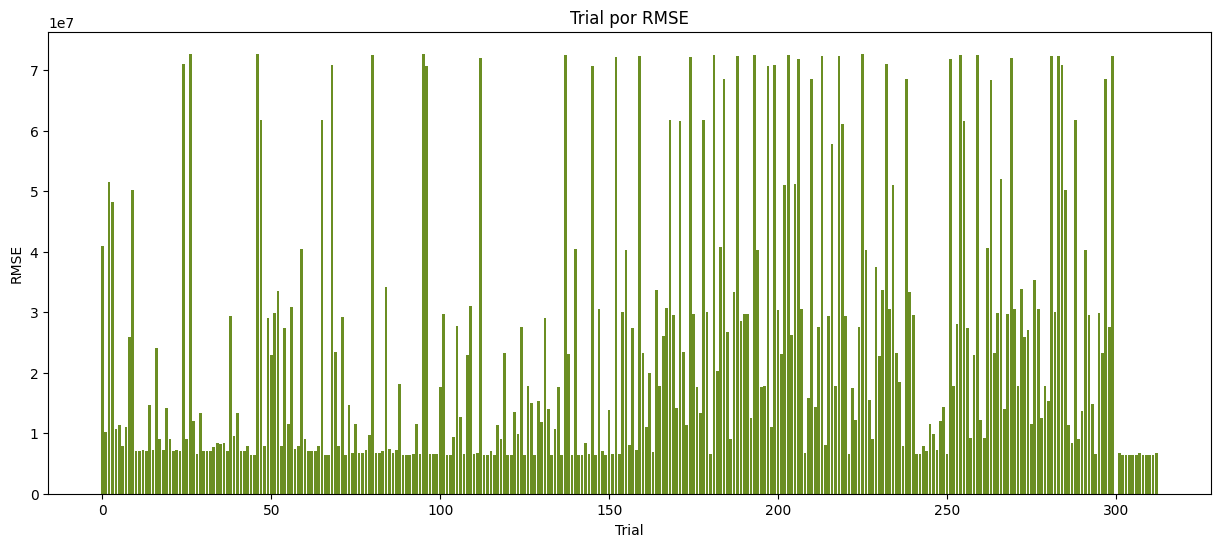

In [15]:
figura, fig_1 = plt.subplots(figsize = (15,6))

fig_1.bar(resultados_otim['Trial'], resultados_otim['RMSE'], color='olivedrab')

fig_1.set_title('Trial por RMSE', loc='center')  
fig_1.set_xlabel('Trial')
fig_1.set_ylabel('RMSE')

plt.show()

Esse gráfico permite observar quais os trials tiveram o melhor desempenho segundo o critério do RMSE, ou seja, quais obtiveram um RMSE menor, sendo nessa optimização o trial $103$.

Então foi feita uma comparação do `Número de árvores` e do `RMSE` obtido em relação a variação desse valor. Primeiro foi feito um histograma.

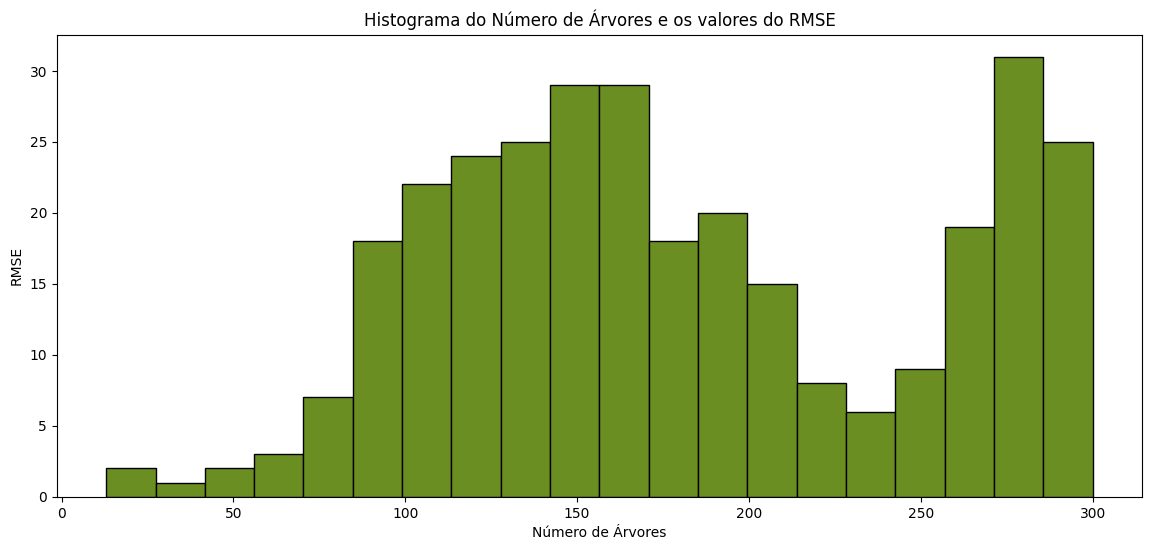

In [16]:
figura, fig_2 = plt.subplots(figsize = (14,6))

fig_2.hist(resultados_otim['Número_de_arvores'], bins=20, color='olivedrab', edgecolor='black')

fig_2.set_title('Histograma do Número de Árvores e os valores do RMSE', loc='center')  
fig_2.set_xlabel('Número de Árvores')
fig_2.set_ylabel('RMSE')

plt.show()


A partir desse histograma é possível observar os Números de Árvores que foram selecionados mais vezes pelo otimizador, como 300 árvores, além de ser possível observar que algumas acumularam um maior valor de RMSE, como valores entre 270 e 300, e entre 100 a 150, aproximadamente.

Para melhor observar a relação entre o Número de árvores e o RMSE, foi feito uma gráfico de barras com essa relação aos mesmos dados.

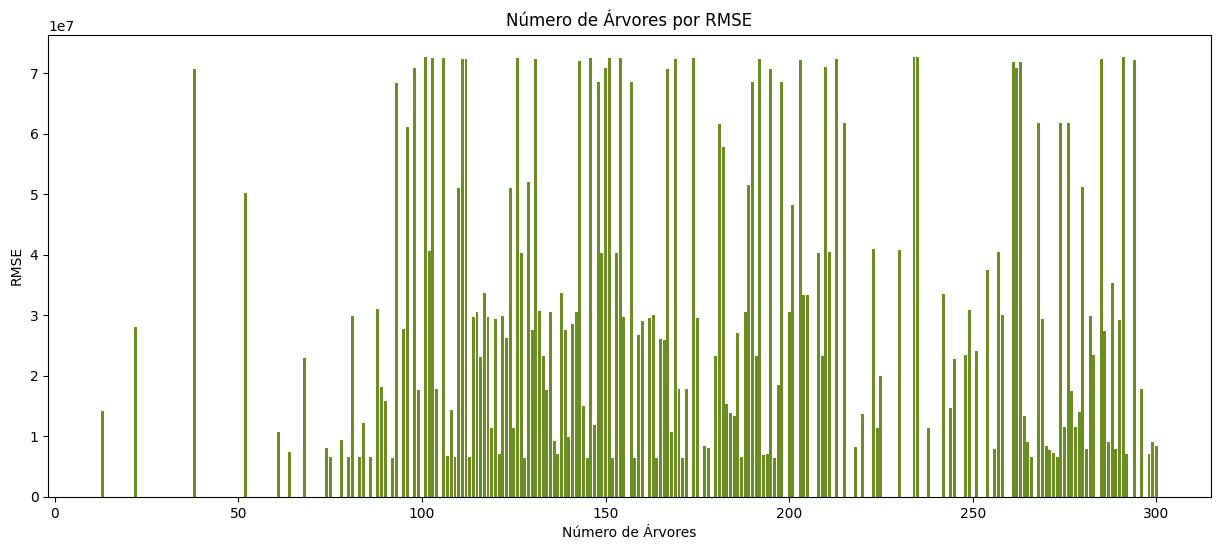

In [17]:
#Gráfico de Trial pelo Mínimo de folhas, sendo as cores correspondentes ao Trial
figura, fig_3 = plt.subplots(figsize = (15,6))

fig_3.bar(resultados_otim['Número_de_arvores'], resultados_otim['RMSE'], color='olivedrab')

fig_3.set_title('Número de Árvores por RMSE', loc='center')  
fig_3.set_xlabel('Número de Árvores')
fig_3.set_ylabel('RMSE')

plt.show()

É possível visualizar melhor a distribuição dos dados, ou seja, quais foram as quantidades de árvores que geraram os menores RMSE. Vale destacar, que o RMSE calculado não diz respeito a variação de apenas um hiperparâmetro, mas de alguns deles, sendo assim essa é uma análise pontual dos dados, tendo como objetivo apenas facilitar a observação e compreensão.

Foi feito dois gráficos, ambos comparando o `Mínimo de Folhas` e o `RMSE` obtido em relação a variação desse valor, em que primeiro foi feito um histograma e depois um gráfico de barras.

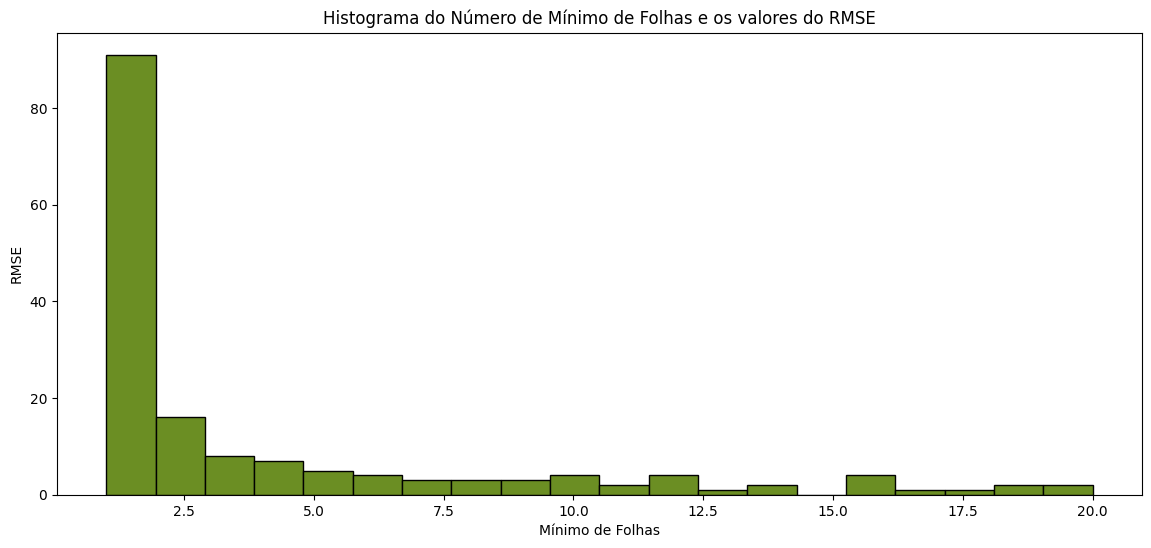

In [18]:
figura, fig_4 = plt.subplots(figsize = (14,6))

fig_4.hist(resultados_otim['Mín_de_folhas'], bins=20, color='olivedrab', edgecolor='black')

fig_4.set_title('Histograma do Número de Mínimo de Folhas e os valores do RMSE', loc='center')  
fig_4.set_xlabel('Mínimo de Folhas')
fig_4.set_ylabel('RMSE')

plt.show()

A partir desse gráfico é possível notar que números menores para o mínimo de folhas apareceram mais vezes e acumularam um RMSE maior. Enquanto isso valores maiores para o mínimo de folhas apareceram menos vezes acumulando menos RMSE.

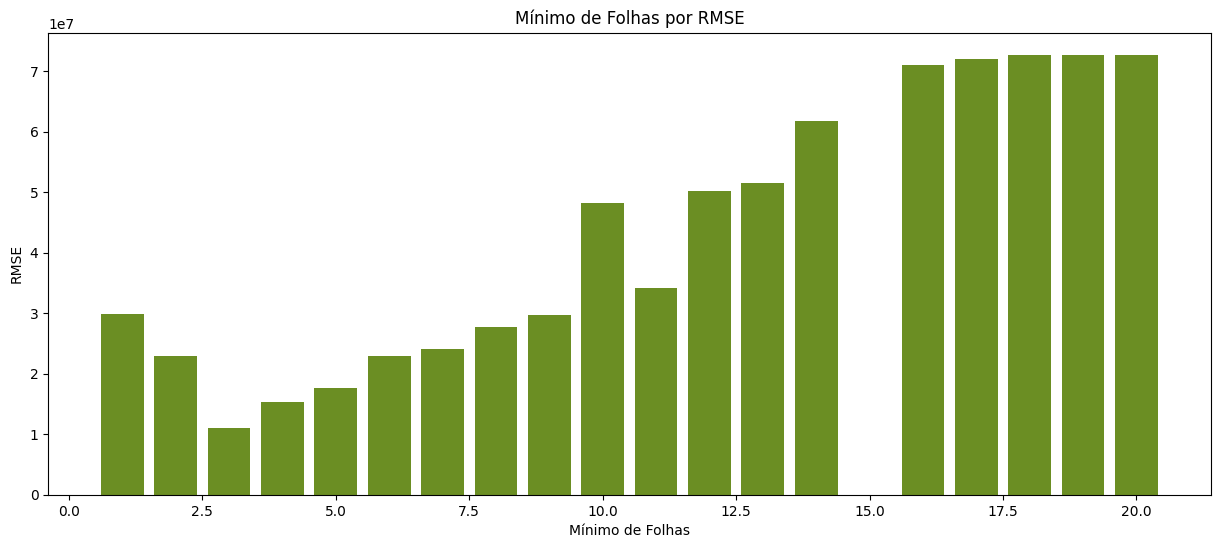

In [19]:
figura, fig_5 = plt.subplots(figsize = (15,6))

fig_5.bar(resultados_otim['Mín_de_folhas'], resultados_otim['RMSE'], color='olivedrab')

fig_5.set_title('Mínimo de Folhas por RMSE', loc='center')  
fig_5.set_xlabel('Mínimo de Folhas')
fig_5.set_ylabel('RMSE')

plt.show()

Esse gráfico mostra que mínimos maiores tendem a apresentar um valor de RMSE maior que mínimos menores. O menor valor para o RMSE ocorreu para o mínimo de folhas igual a 3, demonstrando que esse é o melhor valor achado para o mínimo de folhas. Entretando levando em conta todos os hiperparâmetros e a junção deles o `optuna` chegou ao resultado que o melhor valor para o mínimo de folhas é 1.  

Assim, comparou-se o `Mínimo de Split` e o `RMSE`, também plotando um histograma e um gráfico de barras.

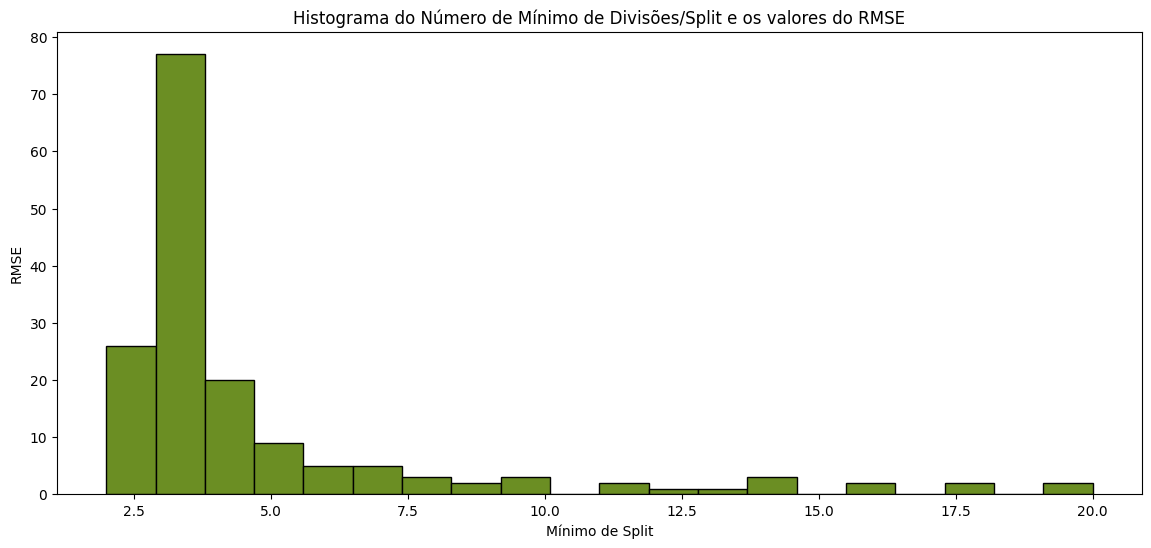

In [20]:
figura, fig_6 = plt.subplots(figsize = (14,6))

fig_6.hist(resultados_otim['Mín_de_split'], bins=20, color='olivedrab', edgecolor='black')

fig_6.set_title('Histograma do Número de Mínimo de Divisões/Split e os valores do RMSE', loc='center')  
fig_6.set_xlabel('Mínimo de Split')
fig_6.set_ylabel('RMSE')

plt.show()

Para o histograma do número mínimo de split é possível notar que mínimos menores aparecem uma quantidade maior de vezes acumulando um RMSE maior.

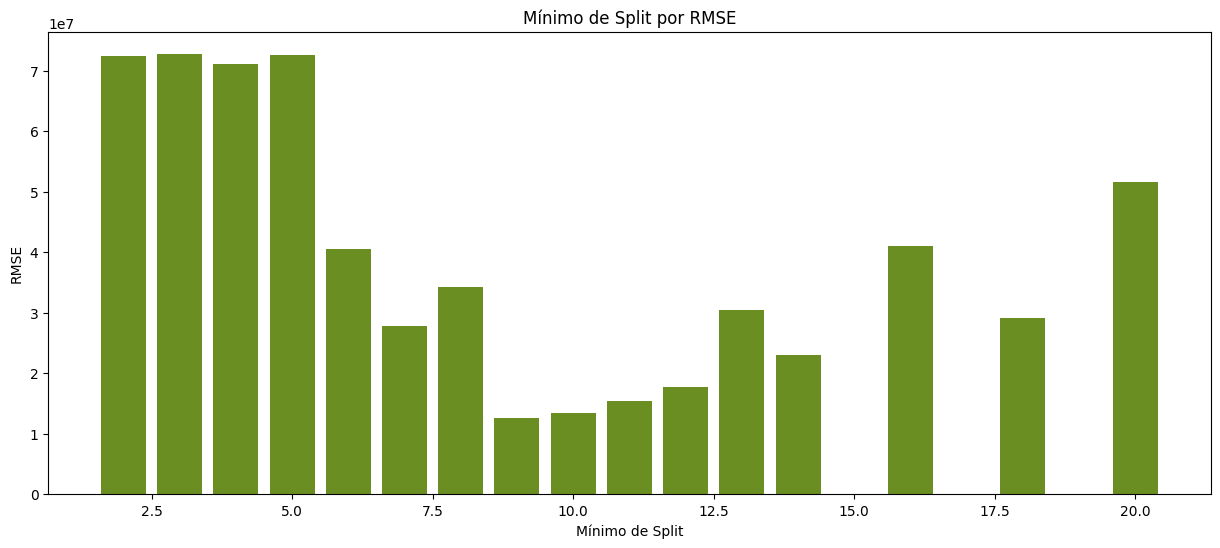

In [21]:
figura, fig_7 = plt.subplots(figsize = (15,6))

fig_7.bar(resultados_otim['Mín_de_split'], resultados_otim['RMSE'], color='olivedrab')

fig_7.set_title('Mínimo de Split por RMSE', loc='center')  
fig_7.set_xlabel('Mínimo de Split')
fig_7.set_ylabel('RMSE')

plt.show()

Mínimos menores tendem a apresentar um RMSE maior que mínimos maiores, entretanto, o menor valor para o RMSE que pode ser observado no gráfico ocorre para o mínimo igual a 9. Considerando todos os hiperparâmetros o `Optuna` deu um resultado para o melhor mínimo de split igual a 3.

### Aplicando o modelo de floresta aleatória para treinar e testar os dados

Assim, foi instanciado o modelo utilizando os hiperparâmetros encontrados a partir da otimização feita com o `Optuna` e com a Validação cruzada, e então fitado com os dados treino. Por fim, foi testado o modelo final com os **dados de teste**.

In [22]:
modelo = cria_instancia_modelo(melhor_trial)
modelo.fit(E_treino, s_treino)

s_verdadeiro = s_teste
s_previsao = modelo.predict(E_teste)

RMSE = mean_squared_error(s_verdadeiro, s_previsao) ** (1/2)

print(RMSE)

5331181.011220705


Por fim, se obteve um modelo de algoritmo de `Floresta Aleatória` com um RMSE ainda menor do que aquele previsto nos treinos feitos com o otimizador, mostrando que foi encontrado um bom modelo, com um RMSE baixo e com boas predições utilizando um modelo que busca diminuir o viés e aumentar a variância em relação a outros modelos como a `Árvore de Decisão`. As implementações de otimização e validação também foram muito importantes para gerar bons resultados.

### Analisando a importância dos atributos, para compreender se algum deles tem uma influência maior

Para concluir, foi feita uma última análise para compreender quais os atributos do DataFrame tiveram maior importância para as predições feitas pelo modelo de `Floresta Aleatória`.

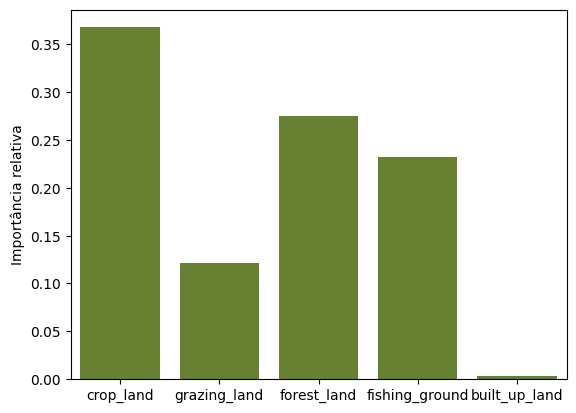

In [23]:
importancia = modelo.feature_importances_

eixo = sns.barplot(x=entradas, y=importancia, color = 'olivedrab')
eixo.set_ylabel("Importância relativa");

Pode-se analisar uma grande variação de importância de cada dado para o treinamento, o que pode ser uma ferramenta de auxílio na hora de analisar os dados do DataFrame e também para futuras coletas de dados para especialistas, e em alguns casos até mesmo a escolher os atributos. Vale ressaltar que isso não diminui a importancia de nenhum desses dados nos estudos sobre ecologia.

# 🔚Conclusão

A partir das análises realizadas no notebook, tais como os gráficos plotados e os valores de RMSE cálculados. Essas análises tornam possível concluir que a  Floresta Aleatória foi uma estratégia eficaz para o treinamento do conjunto de dados escolhido. Isso se torna notório uma vez que os valores de RMSE apresentados foram baixos, sendo esses em torno de $6\cdot10^6$. Tal valor é considerado bom devido ao fato da escala dos dados ser elevada. Sendo que, para grandes escalas de dados um RMSE de até $1\cdot10^7$ é considerado satisfatório. O RMSE é um valor importante, pois quantifica a diferença entre os valores preditos pelo modelo e os valores reais observados. Dessa forma, um RMSE baixo indica que o modelo está fazendo previsões mais precisas, assim, os resultados preditos são mais confiáveis.

Com isso, pode-se concluir que a hipótese proposta pelo grupo no ínicio do projeto é válida. Sendo assim, é possível utilizar Aprendizagem de Máquina, tendo como ponto de partida dados coletados (tais como: área agrícola, área de pastagem, área florestal, área de pesca e áreas construídas), para prever o valor da pegada ecológica total de uma região.

# Referências

[1] Floresta Aleatória: Cassar, Daneil R. "ATP-203 5.1 - Floresta aleatória". Disponível em material didático. 

[2] Hiperparâmetros: Cassar, Daneil R. "ATP-203 4.1 - Árvore de decisão". Disponível em material didático. 

[3] Hiperparâmetros Floresta Aleatória: “RandomForestRegressor”. Scikit-Learn, https://scikit-learn/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html. Acesso em 14 de outubro de 2024.

[4] Optuna: Cassar, Daneil R. "ATP-203 6.1 - Otimização de hiperparâmetros com optuna". Disponível em material didático.

[5] Optuna: FAQ — Optuna 4.0.0 documentation. https://optuna.readthedocs.io/en/stable/faq.html#how-can-i-obtain-reproducible-optimization-results. Acesso em 14 de outubro de 2024.

[6] Raschka, Sebastian. Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning

[7] Silva, Josenildo Costa da. “O Algoritmo Da Floresta Aleatória”. Machina Sapiens, 13 de março de 2018, https://medium.com/machina-sapiens/o-algoritmo-da-floresta-aleat%C3%B3ria-3545f6babdf8.